# spacetrackのテスト その3

長期間の軌道データを調べてみる

In [1]:
import spacetrack.operators as op
from spacetrack import SpaceTrackClient
from datetime import datetime
import numpy as np
import pandas as pd
import time
import json
import os
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
pd.set_option('display.max_columns', 50)
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_colwidth", 80)

In [3]:
# userid and password are set in here
import spacetrackaccount
# print("Login with " + spacetrackaccount.userid)

In [4]:
st = SpaceTrackClient(spacetrackaccount.userid, spacetrackaccount.password)

In [5]:
def mycallback(until):
    duration = int(round(until - time.monotonic()))
    print('Sleeping for {:d} seconds.'.format(duration))

st.callback = mycallback

In [6]:
# Hinodeの軌道データをJSON形式でダウンロード (既にダウンロード済みの場合はそれを使う)
norad_cat_id = 29479
file = 'download/tle_{}_all.json'.format(norad_cat_id)
if not os.path.isfile(file):
    print('Downloading new data')
    data = st.tle(norad_cat_id=norad_cat_id, orderby='epoch', format='json')
    with open(file, 'w') as fp:
        fp.write(data)
    df = pd.read_json(data)
else:
    print('Using pre-existing data')
    df = pd.read_json(file)

Using pre-existing data


In [7]:
# Timestamp型(datetime64[ns])に変換する
df['EPOCH2'] = pd.to_datetime(df['EPOCH'] + '.' + df['EPOCH_MICROSECONDS'].map('{:06}'.format))

In [8]:
# EPOCH2でソートする
df = df.sort_values(['EPOCH2', 'FILE']).reset_index(drop=True)

In [9]:
# EPOCH2が同じデータが複数存在する場合、最後のデータのみを残す
print(len(df))
df = df[~df.duplicated(subset='EPOCH2', keep='last')]
print(len(df))

8451
8401


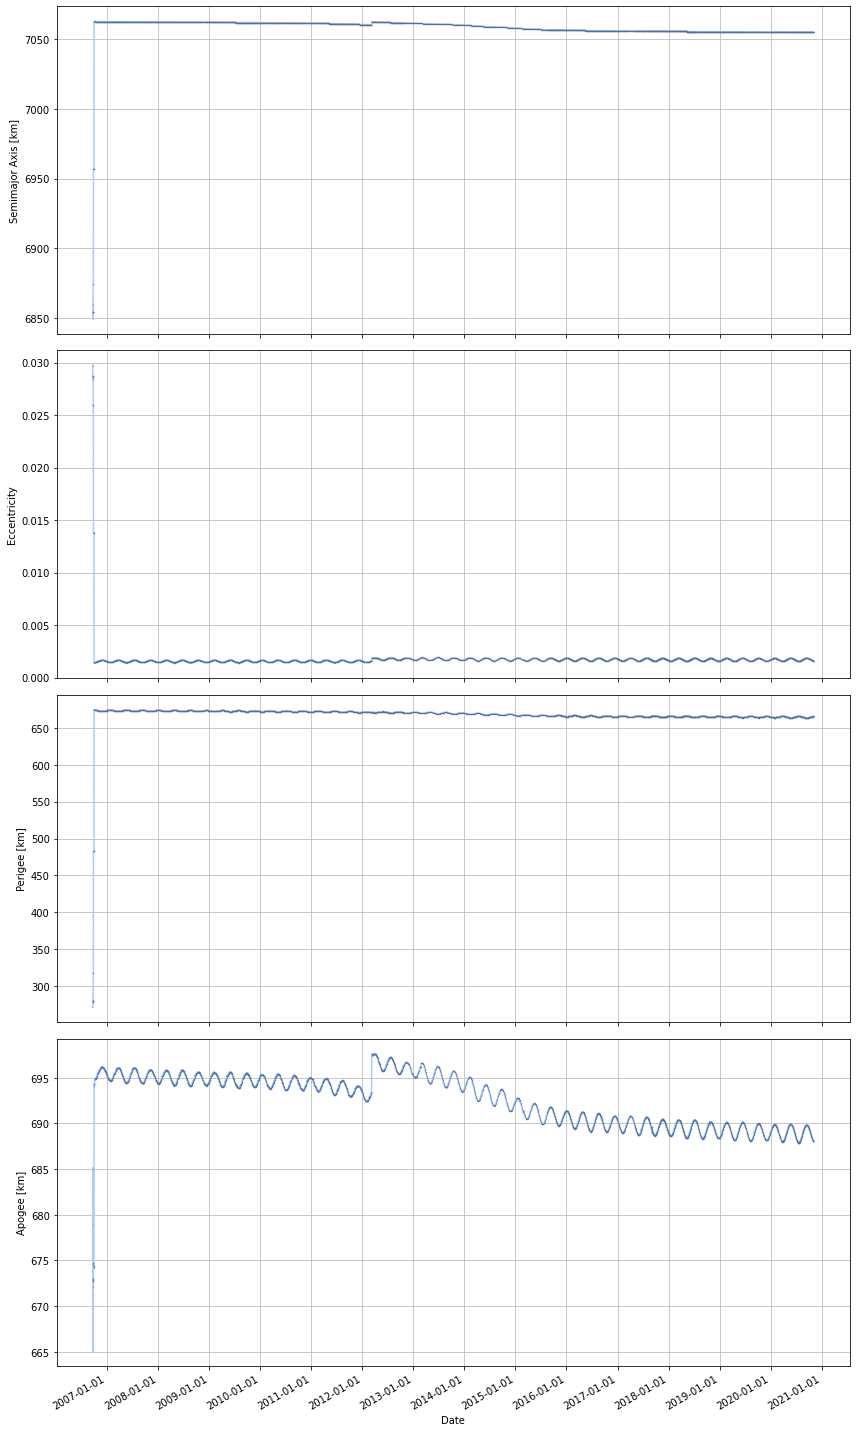

In [10]:
# 軌道長半径、離心率、近地点、遠地点の時間変化をプロット
fig = plt.figure(figsize=(12, 20))
ax1 = fig.add_subplot(4, 1, 1)
ax1.plot(df['EPOCH2'], df['SEMIMAJOR_AXIS'], color='#aaccff', marker='.', markersize=0.3, markeredgecolor='#5070a0')
ax1.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1, bymonth=1, tz=None))
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
ax1.set_xlabel("Date")
ax1.set_ylabel("Semimajor Axis [km]")
ax1.grid(b=True, which='major', color='#bbbbbb', linestyle='-')
ax2 = fig.add_subplot(4, 1, 2)
ax2.plot(df['EPOCH2'], df['ECCENTRICITY'], color='#aaccff', marker='.', markersize=0.3, markeredgecolor='#5070a0')
ax2.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1, bymonth=1, tz=None))
ax2.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
ax2.set_xlabel("Date")
ax2.set_ylabel("Eccentricity")
ax2.grid(b=True, which='major', color='#bbbbbb', linestyle='-')
ax3 = fig.add_subplot(4, 1, 3)
ax3.plot(df['EPOCH2'], df['PERIGEE'], color='#aaccff', marker='.', markersize=0.3, markeredgecolor='#5070a0')
ax3.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1, bymonth=1, tz=None))
ax3.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
ax3.set_xlabel("Date")
ax3.set_ylabel("Perigee [km]")
ax3.grid(b=True, which='major', color='#bbbbbb', linestyle='-')
ax4 = fig.add_subplot(4, 1, 4)
ax4.plot(df['EPOCH2'], df['APOGEE'], color='#aaccff', marker='.', markersize=0.3, markeredgecolor='#5070a0')
ax4.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1, bymonth=1, tz=None))
ax4.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
ax4.set_xlabel("Date")
ax4.set_ylabel("Apogee [km]")
ax4.grid(b=True, which='major', color='#bbbbbb', linestyle='-')
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

In [11]:
# 軌道長半径の時間変化
oneday = pd.Timedelta(days=1)
DT = df['EPOCH2'].diff() / oneday
DSEMIMAJOR_AXIS = df['SEMIMAJOR_AXIS'].diff() / DT

In [12]:
DSEMIMAJOR_AXIS.describe()

count      8400.000000
mean        -26.896714
std        7462.149528
min     -534796.064714
25%          -0.002437
50%          -0.001044
75%           0.000000
max      299999.999970
dtype: float64

In [13]:
(DT * 86400).describe()

count      8400.000000
mean      53022.722862
std       32761.566956
min           0.000863
25%       29507.130576
50%       47279.992464
75%       76834.224215
max      402766.039872
Name: EPOCH2, dtype: float64

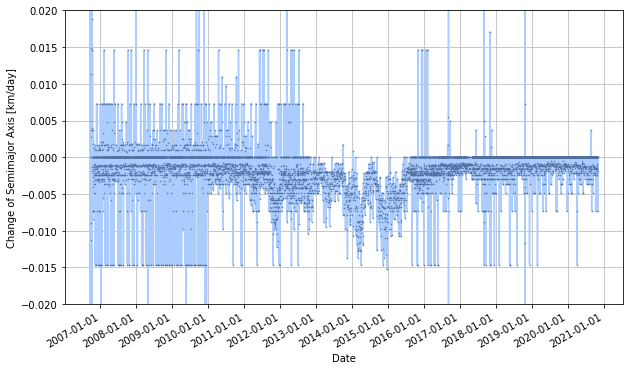

In [14]:
fig = plt.figure(figsize=(10, 6))
ax1 = fig.add_subplot(1, 1, 1)
ax1.plot(df['EPOCH2'], DSEMIMAJOR_AXIS, color='#aaccff', marker='.', markersize=1, markeredgecolor='#5070a0')
ax1.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1, bymonth=1, tz=None))
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
ax1.set_xlabel("Date")
ax1.set_ylabel("Change of Semimajor Axis [km/day]")
ax1.set_ylim(-0.02, 0.02)
ax1.grid(b=True, which='major', color='#bbbbbb', linestyle='-')
fig.autofmt_xdate()
plt.show()

ノイズが多くてよくわからないのでデータを間引く

In [15]:
# 1日平均と週平均 (EPOCH2がインデックスになる)
df2 = df.resample('D', on='EPOCH2').mean()
df3 = df.resample('W', on='EPOCH2').mean()
print(len(df), len(df2), len(df3))

8401 5156 738


In [16]:
# 軌道長半径の時間変化
DSEMIMAJOR_AXIS2 = df2['SEMIMAJOR_AXIS'].diff()
DSEMIMAJOR_AXIS3 = df3['SEMIMAJOR_AXIS'].diff() / 7.0

In [17]:
DSEMIMAJOR_AXIS2.describe()

count    4731.000000
mean        0.042907
std         1.786203
min        -0.709556
25%        -0.002000
50%        -0.001000
75%        -0.000500
max       105.555000
Name: SEMIMAJOR_AXIS, dtype: float64

In [18]:
DSEMIMAJOR_AXIS3.describe()

count    737.000000
mean       0.038807
std        0.818654
min       -0.011524
25%       -0.002562
50%       -0.000957
75%       -0.000669
max       20.015167
Name: SEMIMAJOR_AXIS, dtype: float64

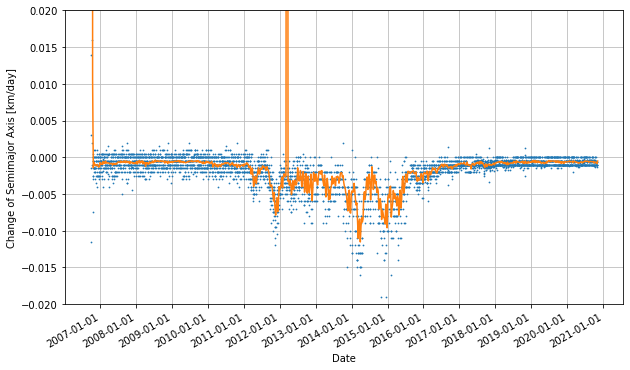

In [19]:
fig = plt.figure(figsize=(10, 6))
ax1 = fig.add_subplot(1, 1, 1)
ax1.plot(df2.index, DSEMIMAJOR_AXIS2, '.', markersize=1.5)
ax1.plot(df3.index, DSEMIMAJOR_AXIS3)
ax1.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1, bymonth=1, tz=None))
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
ax1.set_xlabel("Date")
ax1.set_ylabel("Change of Semimajor Axis [km/day]")
ax1.set_ylim(-0.02, 0.02)
ax1.grid(b=True, which='major', color='#bbbbbb', linestyle='-')
fig.autofmt_xdate()
plt.show()

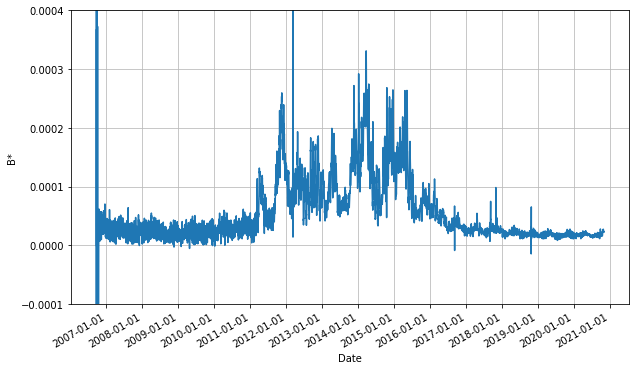

In [20]:
# 抗力項 BSTAR をプロット
fig = plt.figure(figsize=(10, 6))
ax1 = fig.add_subplot(1, 1, 1)
ax1.plot(df['EPOCH2'], df['BSTAR'])
ax1.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1, bymonth=1, tz=None))
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
ax1.set_xlabel("Date")
ax1.set_ylabel("B*")
ax1.set_ylim(-0.0001, 0.0004)
ax1.grid(b=True, which='major', color='#bbbbbb', linestyle='-')
fig.autofmt_xdate()
plt.show()